# Gold's RUB Story

Quarterly processing now zooms in on the GC-F contract and keeps IEF and SBGB only as anchors for covariance diagnostics. The goal is to show how USD volatility translated into an almost uninterrupted climb for Russian investors once USD/RUB is folded in.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import (
    set_style,
    prepare_returns_dataset,
    exp_weights,
    weighted_covariance_matrix,
    nearest_psd,
    compute_ledoit_wolf,
)

set_style()

FREQUENCY = "Q"
BASE_CURRENCY = "RUB"
HALF_LIFE_VOL = 18  # quarters
WINSOR_ALPHA = 0.01
FOCUS_TICKERS = ["GC-F", "IEF", "SBGB"]

dataset = prepare_returns_dataset(
    FOCUS_TICKERS,
    frequency=FREQUENCY,
    base_currency=BASE_CURRENCY,
    winsor_alpha=WINSOR_ALPHA,
)

returns_long = dataset["returns_long"]
q_matrix_log = dataset["matrix_log"][FOCUS_TICKERS].dropna()
fx_series = dataset["fx"].set_index("date")

gold = (
    returns_long[returns_long["asset_id"] == "GC-F"]
    .dropna(subset=["r_local_log", "r_fx_log", "r_base_log", "r_base_log_w"])
    .copy()
)
gold.set_index("date", inplace=True)


## USD vs RUB lens

Gold’s USD journey is choppy; once FX translation is applied, the RUB investor experience becomes almost monotonic.

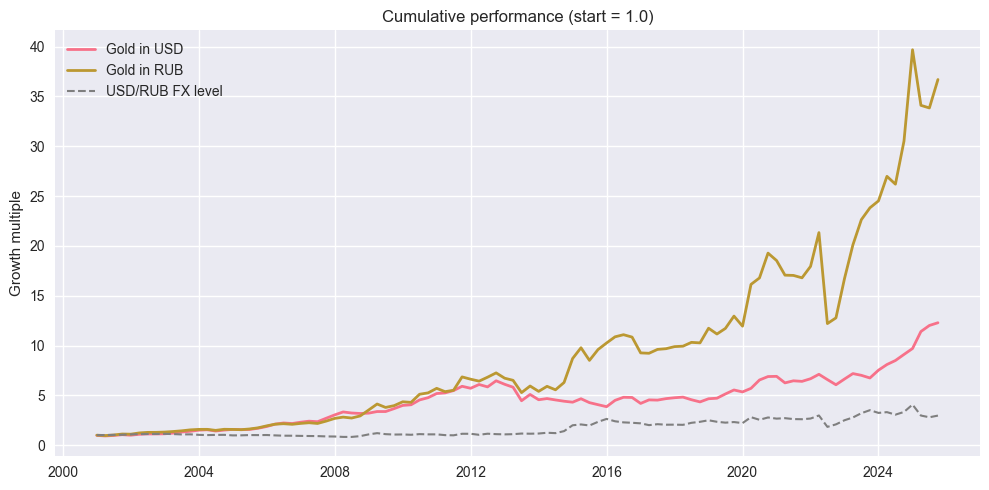

In [7]:
gold_curve = gold[["r_local_log", "r_fx_log", "r_base_log"]].dropna().copy()
gold_curve["usd_index"] = np.exp(gold_curve["r_local_log"].cumsum())
gold_curve["rub_index"] = np.exp(gold_curve["r_base_log"].cumsum())
gold_curve["fx_index"] = np.exp(gold_curve["r_fx_log"].cumsum())

plt.figure(figsize=(10, 5))
plt.plot(gold_curve.index, gold_curve["usd_index"], label="Gold in USD", linewidth=2)
plt.plot(gold_curve.index, gold_curve["rub_index"], label="Gold in RUB", linewidth=2)
plt.plot(
    gold_curve.index,
    gold_curve["fx_index"],
    label="USD/RUB FX level",
    linestyle="--",
    color="tab:gray",
    linewidth=1.5,
)
plt.title("Cumulative performance (start = 1.0)")
plt.ylabel("Growth multiple")
plt.legend()
plt.tight_layout()
plt.show()


## One-year return decomposition

Stacking USD price action against FX shifts makes the RUB outcome intuitive. Each point aggregates the last four quarters.

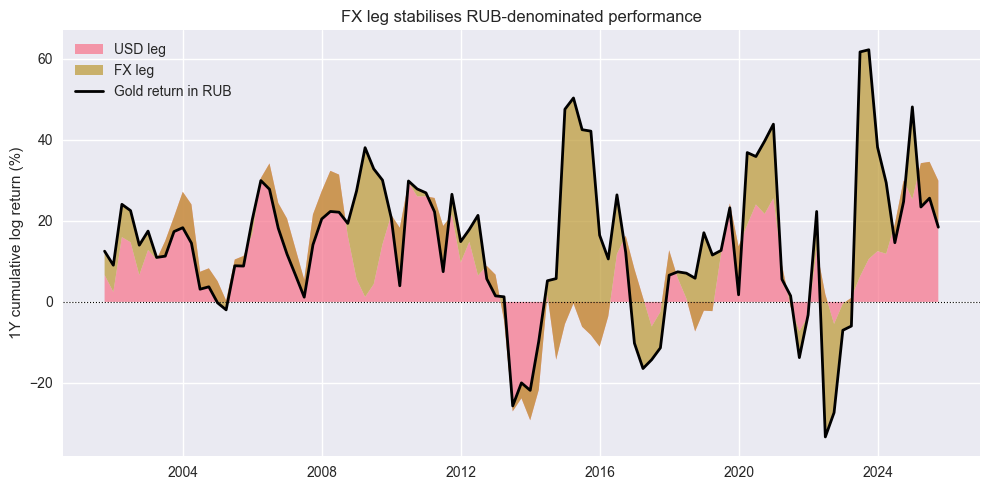

In [8]:
window = 4  # rolling four quarters (~1 year)
decomp = gold[["r_local_log", "r_fx_log"]].rename(columns={"r_local_log": "USD leg", "r_fx_log": "FX leg"})
rolling = decomp.rolling(window=window, min_periods=window).sum().dropna()
total = rolling.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.stackplot(
    rolling.index,
    (rolling["USD leg"] * 100).to_numpy(),
    (rolling["FX leg"] * 100).to_numpy(),
    labels=["USD leg", "FX leg"],
    alpha=0.7,
)
plt.plot(total.index, total * 100, color="black", linewidth=2, label="Gold return in RUB")
plt.axhline(0, color="black", linewidth=0.8, linestyle=":")
plt.ylabel("1Y cumulative log return (%)")
plt.title("FX leg stabilises RUB-denominated performance")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


## Winsorisation keeps crashes narratable

Quarterly shocks are clipped at the 1% tails before any statistics are produced.

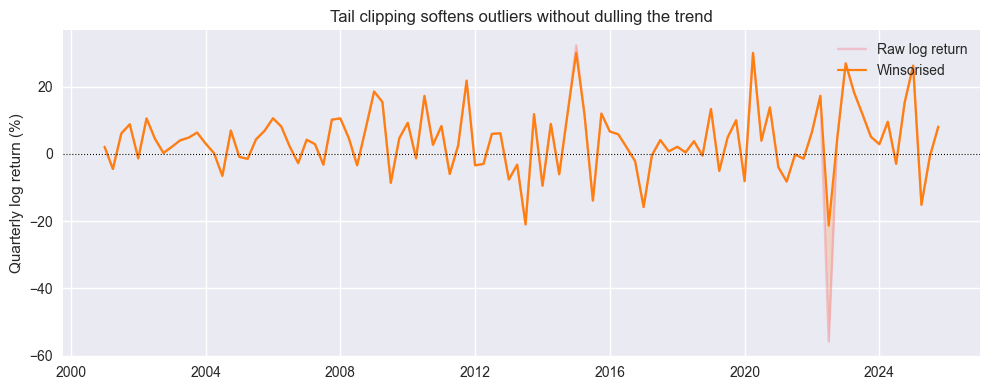

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(gold.index, gold["r_base_log"] * 100, alpha=0.35, label="Raw log return")
plt.plot(gold.index, gold["r_base_log_w"] * 100, color="tab:orange", linewidth=1.6, label="Winsorised")
plt.fill_between(
    gold.index,
    gold["r_base_log"] * 100,
    gold["r_base_log_w"] * 100,
    color="tab:orange",
    alpha=0.2,
)
plt.axhline(0, color="black", linewidth=0.8, linestyle=":")
plt.ylabel("Quarterly log return (%)")
plt.title("Tail clipping softens outliers without dulling the trend")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


## Exponential weighting & covariance diagnostics

IEF (USD Treasuries) and SBGB (local RU bonds) provide contrast assets for correlation and shrinkage checks.

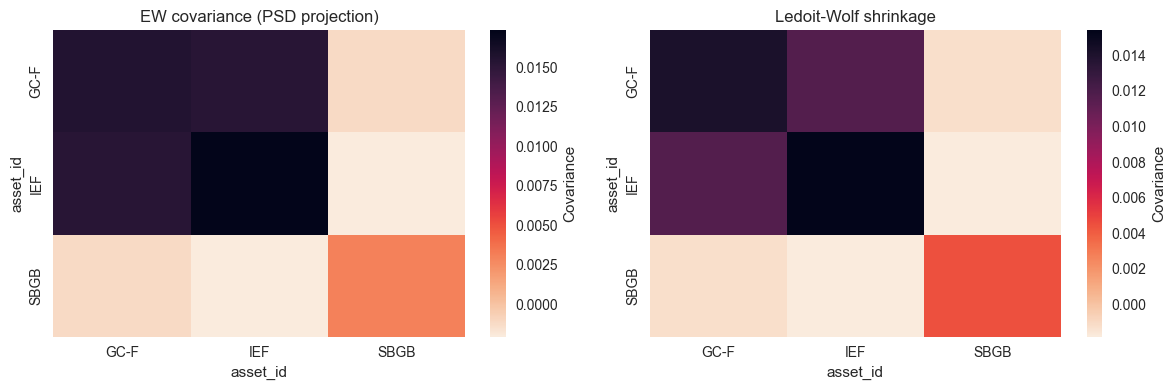

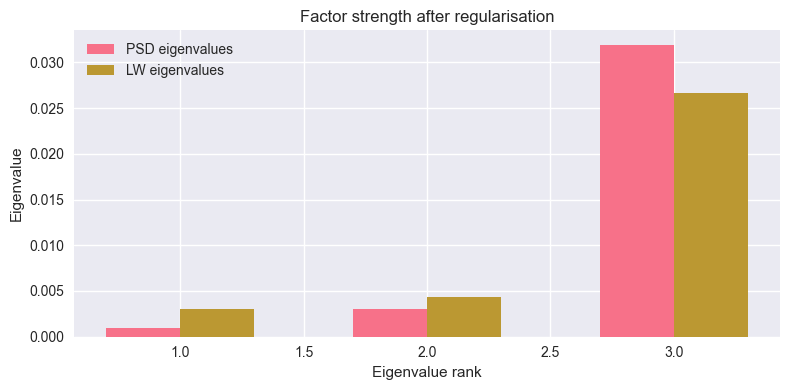

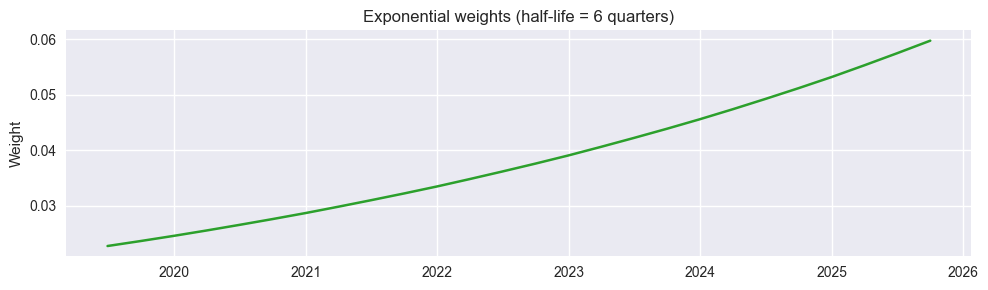

In [10]:
weights = exp_weights(q_matrix_log.index, half_life=HALF_LIFE_VOL)
weights_sorted = weights.sort_index()

ew_cov = weighted_covariance_matrix(q_matrix_log, weights)
psd_cov = nearest_psd(ew_cov)
lw_cov = compute_ledoit_wolf(q_matrix_log)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(psd_cov, cmap="rocket_r", ax=axes[0], cbar_kws={"label": "Covariance"})
axes[0].set_title("EW covariance (PSD projection)")

if lw_cov is not None:
    sns.heatmap(lw_cov, cmap="rocket_r", ax=axes[1], cbar_kws={"label": "Covariance"})
    axes[1].set_title("Ledoit-Wolf shrinkage")
else:
    axes[1].axis("off")
    axes[1].set_title("Ledoit-Wolf shrinkage unavailable")

plt.tight_layout()
plt.show()

eig_psd = np.linalg.eigvalsh(psd_cov)
eig_lw = np.linalg.eigvalsh(lw_cov) if lw_cov is not None else None

plt.figure(figsize=(8, 4))
positions = np.arange(1, len(eig_psd) + 1)
plt.bar(positions - 0.15, eig_psd, width=0.3, label="PSD eigenvalues")
if eig_lw is not None:
    plt.bar(positions + 0.15, eig_lw, width=0.3, label="LW eigenvalues")
plt.title("Factor strength after regularisation")
plt.xlabel("Eigenvalue rank")
plt.ylabel("Eigenvalue")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(weights_sorted.index, weights_sorted.values, color="tab:green", linewidth=1.8)
plt.title("Exponential weights (half-life = 6 quarters)")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()


## Takeaways

- Gold’s RUB path compounds FX devaluation; the USD drawdowns barely dent the long-run climb.
- FX decomposition makes the base-currency story legible: the currency leg contributes most of the upside.
- Winsorised returns keep diagnostics robust, while EW covariance + PSD/LW clean the risk surface for allocation work.